## Import

In [7]:
# !pip install cv2
# !pip install moviepy
# !pip install mediapipe
# !pip install config
import cv2
import mediapipe as mp
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
from mpl_toolkits.mplot3d import Axes3D # 3D 시각화
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from pywt import wavedec
# #f_detector import
# from imutils.video import VideoStream
# import f_detector #만든 detector 라이브러리 
# import imutils 

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

## 사용 알고리즘 및 함수툴 정의

In [50]:
## 얼굴 외곽 마스크 생성 방법
def face_outline_masking(results, landmark_dict, image):
    # 얼굴 외곽 정의한 것 가지고 얼굴 외곽 좌표 추출
    face_outline_coords = [
        (int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1]),
        int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0]))
        for i in landmark_dict['Outline_face']] 

    # 얼굴 외곽 마스크 생성
    mask = np.zeros_like(image)
    
    # 얼굴 부분을 빨간색으로 만들기
    cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (0, 0, 255))  # R : BGR 순서
    # cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (0, 255, 0))  # G : BGR 순서
    # cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (255, 0, 0))  # B : BGR 순서
    
    # 얼굴 마스크 적용
    masked_face = cv2.bitwise_and(image, mask)
    # 원본 영상에 얼굴 마스크 덧씌우기
    masked_image = cv2.addWeighted(image, 1, masked_face, 0.5, 0.1)  
    # 얼굴 영역 좌표 구하기
    x, y, w, h = cv2.boundingRect(np.array(face_outline_coords, dtype=np.int32))
    # 얼굴 내부 부분에 박스 그리기
    cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # 얼굴에 bounding box 이름 추가
    text_size = cv2.getTextSize('Face', cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, 1)[0]
    cv2.putText(masked_image, 'Face', (x + (w - text_size[0]) // 2, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # 얼굴 마스크 적용
    masked_face = cv2.bitwise_and(masked_image, mask)
    # 원본 영상에 얼굴 마스크 덧씌우기
    masked_image = cv2.addWeighted(masked_image, 1, masked_face, 0.8, 0.1)
    return masked_face, masked_image, x,y, x+w, y+h, 


## hanging_cnt_v1 : z-score normal 후 부호를 이용해서 머리흔들림이 심한 프레임에 대해서 부호로 머리흔들림 스코어링 선정 -> 잘안될떄가 있다.
def hanging_cnt_v1(hanging_frame):
    #움직임에 대한 변화량을 z_score_normalization 함
    movement_array = z_score_norm(np.array(hanging_frame)[:,1])
    # print(f"sign change check for z_score_movement : {np.sign(movement_array)}")
    # movement_array = z_score_norm(hanging_frame[:,1])

    # 부호 변경 횟수를 카운트할 변수
    sign_change_count = 0

    # 이전 움직임의 부호 초기화
    previous_sign = np.sign(movement_array[0])

    # 배열을 순회하면서 부호 변경 횟수를 계산
    for i in range(1, len(movement_array)):
        current_sign = np.sign(movement_array[i])
        
        # 부호가 변경되면 카운트 증가
        if current_sign != previous_sign:
            # 다음 움직임이 다시 원래 부호로 돌아올 때만 카운트 증가
            if i + 1 < len(movement_array) and np.sign(movement_array[i + 1]) == previous_sign:
                # print(hanging_frame[])
                sign_change_count += 1
        
        previous_sign = current_sign

    print(f"v1_틱 증상  : {sign_change_count}")

## hanging_cnt_v2 : 프레임의 대한 범위를 지정해서 하나의 그룹으로 묶는다. 단점 : 프레임 범위인 threshold를 정해줘야함.
def hanging_cnt_v2(frames, threshold):
    # 그룹을 저장할 리스트
    groups = []

    # 현재 그룹에 속하는 프레임들을 저장할 리스트
    current_group = [frames[0]]

    # 프레임별로 그룹을 묶음
    for i in range(1, len(frames)):
        # 현재 프레임과 이전 프레임의 차이가 10프레임을 넘지 않으면 같은 그룹으로 묶음
        if frames[i] - frames[i-1] <= threshold:
            current_group.append(frames[i])
        else:
            # 차이가 10프레임을 넘으면 새로운 그룹 시작
            groups.append(current_group)
            current_group = [frames[i]]

    # 마지막 그룹 추가
    groups.append(current_group)
    # 결과 출력
    return len(groups)
    
def is_eye_closed(results, landmark_dict, image, threshold, tag):
    # 눈 가/세로 높이 정하기 위한 랜드마크 정의한 것 가지고 눈 좌표 추출
    # eye_blink_coords = np.array([
    #     (results.multi_face_landmarks[0].landmark[i].x,
    #     results.multi_face_landmarks[0].landmark[i].y)
    #     for i in landmark_dict[tag +'_eye_blink']])
    eye_blink_coords = np.array([
        (int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1]),
        int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0]))
        for i in landmark_dict[tag +'_eye_blink']])    
    
    # 눈 중심좌표 계산 
    eye_center = np.mean(eye_blink_coords, axis = 0)
    
    # 눈의 높이와 폭 계산
    eye_height = np.linalg.norm(eye_blink_coords[1] - eye_blink_coords[3])
    eye_width = np.linalg.norm(eye_blink_coords[0] - eye_blink_coords[2])

    # # 눈의 종횡비 계산
    aspect_ratio = eye_width / eye_height
    
    # # 눈이 감겨 있는지 여부를 판단
    # 임의의 임계값, 실험을 통해 조절
    if aspect_ratio > threshold:
        return 1, aspect_ratio
    else:
        return 0, aspect_ratio


#영역 부피 저장 함수
def save_area(area_array, tag, video_info):
    np.save(os.path.join('./data/np', str(video_info['path'].split('/')[-1].split('.')[0] + f'_{tag}')),area_array)

    
def z_score_norm(arr):
    # z-score normalization
    mean_val = np.mean(arr)
    std_dev = np.std(arr)
    return (arr - mean_val) / std_dev

# 전체 histogram 
def total_weight_score(hanging_score, unpair_blink_score, blink_score, w1, w2, w3):
    total = w1 * hanging_score + w2 * unpair_blink_score + w3 * blink_score 
    caused_tic_percent = total /(w1+w2+w3)
    # 틱 장애 위험도 
    return caused_tic_percent 

#머리를 흔드는 것에 대한 점수화 
def hanging_face_score(cnt, play_time, threshold):
    score = (cnt/play_time) * threshold
    if score < 0.5:
        return 0
    elif score >= 0.5 and score < 1.0:
        return 0.2
    elif score >= 1.0 and score < 1.5:
        return 0.4
    elif score >= 1.5 and score < 2.0:
        return 0.6
    elif score >= 2.0 and score < 2.5:
        return 0.8
    else:
        return 1.0

## 비대칭적으로 눈 감는 횟수를 점수화
def unpair_eye_blink_score(left_cnt, right_cnt, threshold):
    # 0~1 사이로 정규화
    abs_cnt = abs(left_cnt - right_cnt)
    if abs_cnt // threshold == 0: #기준치보다 미달일경우 0점 할당 
        return 0
    else: #0.2, 0.4, 0.6, 0.8, 1.0
        if abs_cnt // threshold == 1: 
            return 0.2
        elif abs_cnt // threshold == 2: 
            return 0.4
        elif abs_cnt // threshold == 3: 
            return 0.6
        elif abs_cnt // threshold == 4: 
            return 0.8
        else:
            return 1.0
        
## 평균적으로 1분에 10~15회 즉 5초에 1회정도 눈을 감는다를 정의 
def blink_equal_score(left_cnt, right_cnt, play_time, threshold):
    equal_cnt = ((left_cnt + right_cnt)/2) // play_time * threshold #threhold 시간당 1번 감는 평균 횟수 되는거임
    if equal_cnt < 1:
        return 0
    elif equal_cnt == 2:
        return 0.2
    elif equal_cnt == 3:
        return 0.4
    elif equal_cnt == 4:
        return 0.6
    elif equal_cnt == 5:
        return 0.8
    else:
        return 1.0


## Data load & Preprocessing

In [254]:
TEST_PATH = './data'
ANALYSIS_PATH = './data/analysis/'
PATH = './data/backup/tic'
NON_TIC_PATH = './data/backup/non-tic'
SAVE_PATH = './result'
# video_data = os.path.join(PATH, '40.mp4') 
# video_data = os.path.join(PATH, '28.mp4') 
# video_data = os.path.join(PATH, '21.mp4') 
# video_data = os.path.join(PATH, '34.mp4') 
# video_data = os.path.join(PATH, '37.mp4') 
# video_data = os.path.join(PATH, '26.mp4')

#분석 데이터 
video_data = os.path.join(ANALYSIS_PATH, 'non-tic_4.mp4') 
# video_data = os.path.join(ANALYSIS_PATH, 'non-tic_1.mp4') 
# 강아지
# video_data = os.path.join(TEST_PATH, 'dog.mp4') 

## 일반인
# video_data = os.path.join(NON_TIC_PATH, '20.mp4') 

cap = cv2.VideoCapture(video_data) #<- video data  / streaming data -> cv2.VideoCapture(0)



## 불러온 비디오 파일 정보 출력
video_info = {
    'name' : video_data.split('/')[-1].split('.')[0],
    'path' : video_data,
    'fps' : cap.get(cv2.CAP_PROP_FPS),
    'total frame' : int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), # 프레임수
    'width' : int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), # 가로 길이
    'height' : int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), # 세로 길이
    "running_time('s)" : int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // int(cap.get(cv2.CAP_PROP_FPS))
}
## 비디오 저장 객체 만들기
out = cv2.VideoWriter(
    os.path.join(SAVE_PATH, ('masked_' + video_data.split('/')[-1].split('.')[0]))+".mp4",
    cv2.VideoWriter_fourcc(*'DIVX'),
    video_info['fps'],
    (video_info['width'], video_info['height'])
    )


print(f"Video Information : {video_info}")


#여러 지점 좌표
landmark_dict = {
    #왼쪽눈
    'L_eye' : [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7], #시계방향 9시부터 시작
    #오른쪽눈
    'R_eye' : [369, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382], #시계방향 9시부터 시작
    #왼쪽 눈동자
    'L_iris' : [470, 471,469, 472, 468], #위에서부터 Up, Left, Right, Down, Center position
    #오른쪽 눈동자
    'R_iris' : [475, 476, 474, 477, 473],
    #왼쪽 눈썹
    'L_eyebrow' : [70, 63, 105, 66, 107, 55, 65, 52 ,53, 46], #시계방향 9시부터 시작
    #오른쪽 눈섭
    'R_eyebrow' : [336, 296, 334, 293, 300, 276, 283, 282, 295 ,285], #시계방향 9시부터 시작
    #윗 입술
    'Up_lips' : [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 391, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191, 78],#시계방향 9시부터 시작
    #아랫 입술
    'Down_lips' : [61, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 391, 375, 321, 405, 314, 17, 84, 181, 91, 146],#시계방향 9시부터 시작
    #입술 안
    'Inner_lips' : [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95],#시계방향 9시부터 시작
    #얼굴외곽
    'Outline_face' : 
        [234, 127, 162, 21, 54, 103, 67, 109, 10, 338, 297, 332, 284,
         251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400,
         377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93],
    'L_eye_blink' : [33, 159, 133, 145],
    'R_eye_blink' : [362, 386, 263, 374], 
}

Video Information : {'name': 'non-tic_4', 'path': './data/analysis/non-tic_4.mp4', 'fps': 30.0, 'total frame': 322, 'width': 1080, 'height': 1920, "running_time('s)": 10}


## Main Act Code

In [255]:
### Configure Varaible 
## Video Setting
cap = cv2.VideoCapture(video_data) # video load 
drawing_spec = mp_drawing.DrawingSpec(thickness = 3, circle_radius = 3)

## 얼굴 랜드마크 검출 객체
landmark = []

## fps 탐지
import time
start_time = time.time()

## 머리 흔들기 객체
hanging_cnt = 0
hanging_threshold = 0.03
hanging_frame = []

## 눈 감기는 횟수 객체 
left_eye_closed_cnt = 0
right_eye_closed_cnt = 0
eye_blink_threshold = 5 # 눈 감길때 논의 종횡비 계산 threshold
blink_frame = []


### Video Action Code
with mp_face_mesh.FaceMesh(  
        max_num_faces=3, #최대 검출 얼굴 개수
        refine_landmarks=True, # 눈과 입술 주변 랜드마크 정교하게 검출시 True
        min_detection_confidence=0.5, #최소 Detection 기준
        min_tracking_confidence=0.5, #최소 traicking 기준
        static_image_mode=True) as face_mesh:
    frame = 1
    while cap.isOpened():
        # print(f"frame : {frame} frame")
        
        ret, image = cap.read()
        # 현재 시간과 이전 시간과의 경과 시간 계산
        elapse_time = time.time() - start_time
        
        # 현재 fps 계산
        fps = 1 / elapse_time
        
        # if not ret:
        #     print("웹캠을 찾을 수 없습니다.")
        #     # 비디오 파일의 경우 'continue'를 사용하시고, 웹캠에 경우에는 'break'를 사용하세요
        #     # continue
        #     break
        if not ret: #영상 더 가지고 올게 없으면 끝내기
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            break
        else: #영상 진행 중일때 
            # 필요에 따라 성능 향상을 위해 이미지 작성을 불가능함으로 기본 설정합니다.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(image)

            # 이미지 위에 얼굴 그물망 주석을 그립니다.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_tesselation_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_contours_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_IRISES,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_iris_connections_style())
                    
                    ## masking 및 박스 플랏 이미지
                    masked_face, masked_image, x,y, x_w, y_h,  = face_outline_masking(results, landmark_dict, image)
                    
                    ## 눈 깜빡임 횟수 정의is_eye_closed
                    l_cnt, left_eye_landmarks = is_eye_closed(results, landmark_dict, image, eye_blink_threshold, tag = 'L')    
                    r_cnt, right_eye_landmarks = is_eye_closed(results, landmark_dict, image, eye_blink_threshold, tag = 'R')    
                    # 프레임 별로 저장
                    blink_frame.append([frame, left_eye_landmarks, right_eye_landmarks])
                    # 눈 깜빡임 횟수 추가
                    left_eye_closed_cnt += l_cnt
                    right_eye_closed_cnt += r_cnt

                    ## 프레임 구간별(default : 10fps) 얼굴 움직임 변화량 측정
                    # 현재 랜드마크 좌표
                    current_landmark = np.array([(point.x, point.y, point.z) for point in face_landmarks.landmark])
                    if frame == 1: #첫 번쨰 프레임일떄는
                        # 현재 랜드마크를 이전 랜드마크로만 저장
                        previous_landmark = current_landmark
                        tag_detected = False
                        tag = 0
                        distances = 0
                        continue
                    else:
                        # 모든 랜드마크의 변화량 계산
                        distances = np.linalg.norm(np.abs(current_landmark - previous_landmark), axis=1)
                        # 평균변화량 출력 : Heuristic threshold Setting 0.05  
                        if np.mean(distances) > hanging_threshold:
                            # print(f"Landmark Movement|frame :{np.mean(distances)}|{frame}")
                            hanging_frame.append([frame, np.mean(distances)])
                            tag_detected = True 
                            tag += 1
                        else:
                            tag_detected = False
                        # 현재 랜드마크를 이전 랜드마크로 저장
                        previous_landmark = current_landmark



            try:
                landmark.append(results.multi_face_landmarks)        
            except TypeError:
                continue
            
            ## FPS 표시
            cv2.putText(masked_image, f"FPS : {fps:.2f}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            ## frame 표시
            cv2.putText(masked_image, f"Frame : {frame}", (0, video_info['height']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) 
            ## 초 표시
            second_record = (frame / video_info['fps'])
            cv2.putText(masked_image, f"Play time : {second_record:.2f}sec", (video_info['width']-180, video_info['height']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) 
                        
            ## 눈이 감겼을 때 메시지 추가
            if l_cnt == 1: #눈 감겼을때 cnt = 1로 지정한 것으로 판단 x,y, x_w, y_h
                cv2.putText(masked_image, f"R_Blink : {right_eye_landmarks/10:.2f}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink {right_eye_closed_cnt}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            else:
                cv2.putText(masked_image, f"R_Blink : {right_eye_landmarks/10:.2f}", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink : {right_eye_closed_cnt}", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

            if r_cnt == 1: #눈 감겼을때 cnt = 1로 지정한 것으로 판단
                cv2.putText(masked_image, f"L_Blink : {left_eye_landmarks/10:.2f}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink : {left_eye_closed_cnt}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            else:
                cv2.putText(masked_image, f"L_Blink : {left_eye_landmarks/10:.2f}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink : {left_eye_closed_cnt}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            
            
            ## 얼굴 큰 흔들림 태그 감지 및 횟수 메시지 추가
            if tag_detected:
                cv2.putText(masked_image, "Head hadly shake detect!!", ((x+x_w)//2, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(masked_image, f"Head Hanging Count : {tag} | {np.mean(distances*10):.2f}", (video_info['width']-250, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA) 
            else:
                cv2.putText(masked_image, f"Head Hanging Count : {tag} | {np.mean(distances*10):.2f}", (video_info['width']-250, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) 
            

            
            # 보기 편하게 이미지를 좌우 반전합니다.
            # edge_image = cv2.Canny(image, 100, 255)
            
            # cv2.imshow('MediaPipe Face Mesh(Puleugo)', image)
            cv2.imshow('MediaPipe Face Mesh(Puleugo)', masked_image)
            # cv2.imshow('MediaPipe Face Mesh(Puleugo)', frame_image)
            
            # 현재 시간 갱신
            start_time = time.time()
            
            ## 동영상 파일 저장
            out.write(masked_image)
            
            # Esc 누르면 영상 종료
            if cv2.waitKey(5) & 0xFF == 27:
                #맥에서 opencv 안닫힐때 꿀팁
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                cv2.waitKey(1)
                cv2.waitKey(1)
                cv2.waitKey(1)
                break
        frame += 1
cap.release()
out.release()
### Algorithms Result
# hanging_cnt_v1(hanging_frame)
hanging_cnt = hanging_cnt_v2(np.array(hanging_frame)[:,0], threshold= video_info['fps']//2)
print(f"v2_틱 증상 횟수 : {hanging_cnt}번")
print(f"left_eye_blink_cnt : {left_eye_closed_cnt}회")
print(f"right_eye_blink_cnt : {np.mean(left_eye_closed_cnt + right_eye_closed_cnt)}회")
print(f"right_eye_blink_cnt : {right_eye_closed_cnt}회")
print(f"unpair_eye_blink_cnt : {abs(right_eye_closed_cnt - left_eye_closed_cnt)}회\n")


### Scoring System
hanging_score = hanging_face_score(hanging_cnt, second_record, threshold = 3) #5초당 평균 머리 흔들기 횟수 점수화
print(f"평균 머리 흔들기 횟수 점수 : {hanging_score}")
unpair_blink_score = unpair_eye_blink_score(left_eye_closed_cnt, right_eye_closed_cnt, threshold = 3)
print(f"비대칭 눈감기 점수 : {unpair_blink_score}")
blink_score = blink_equal_score(left_eye_closed_cnt, right_eye_closed_cnt, second_record, threshold = 5)
print(f"평균 눈 감는 횟수 점수 : {blink_score}")
print(f"Long time : 졸린 정도 : {((left_eye_closed_cnt+right_eye_closed_cnt)/2)/video_info['total frame'] * 100}%")

### Total Score
w1 = 0.6 #머리흔들기 가중치
w2 = 0.3 #짝눈 가충치
w3 = 0.1 #눈감기 가중치
total_score = total_weight_score(hanging_score, unpair_blink_score, blink_score, w1, w2, w3)
print(f"틱 장애 위험도 : {total_score*100:.2f}점 (0~30:정상/30~60:경증/60~100:중증) *w1 : {w1}, w2 : {w2}, w3 : {w3}")
print(f"{video_info['total frame']}")
### Check

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [256]:
print(f"left_eye_blink_cnt : {left_eye_closed_cnt}회")
print(f"right_eye_blink_cnt : {np.mean(left_eye_closed_cnt + right_eye_closed_cnt)}회")
print(f"right_eye_blink_cnt : {right_eye_closed_cnt}회")
print(f"unpair_eye_blink_cnt : {abs(right_eye_closed_cnt - left_eye_closed_cnt)}회\n")

unpair_blink_score = unpair_eye_blink_score(left_eye_closed_cnt, right_eye_closed_cnt, threshold = 3)
print(f"비대칭 눈감기 점수 : {unpair_blink_score}")
blink_score = blink_equal_score(left_eye_closed_cnt, right_eye_closed_cnt, second_record, threshold = 5)
print(f"평균 눈 감는 횟수 점수 : {blink_score}")
print(f"Long time : 졸린 정도 : {((left_eye_closed_cnt+right_eye_closed_cnt)/2)/video_info['total frame'] * 100}%")

### Total Score
w1 = 0.6 #머리흔들기 가중치
w2 = 0.3 #짝눈 가충치
w3 = 0.1 #눈감기 가중치
total_score = total_weight_score(hanging_score, unpair_blink_score, blink_score, w1, w2, w3)
print(f"틱 장애 위험도 : {total_score*100:.2f}점 (0~30:정상/30~60:경증/60~100:중증) *w1 : {w1}, w2 : {w2}, w3 : {w3}")
print(f"{video_info['total frame']}")

left_eye_blink_cnt : 10회
right_eye_blink_cnt : 24.0회
right_eye_blink_cnt : 14회
unpair_eye_blink_cnt : 4회

비대칭 눈감기 점수 : 0.2
평균 눈 감는 횟수 점수 : 0.8
Long time : 졸린 정도 : 3.7267080745341614%
틱 장애 위험도 : 14.00점 (0~30:정상/30~60:경증/60~100:중증) *w1 : 0.6, w2 : 0.3, w3 : 0.1
322


# Analysis

## Feature Analysis
* 세팅
* 랜드마크 분석 x,y,z좌표 제대로 나왔는지 확인
* 틱 관련 중요 부위 영역(넓이) 분석 * x,y만 이용 
* 짝눈 분석 : 두 눈의 영역 차이 변화도를 이용한 점수화 threshold 정하기
* 눈 감는 횟수 분석 : 두 눈의 감는 횟수를 평균적으로 구하여  점수화 threshold 정하기
* 머리 흔들림 차이 분석 : 흔들림에 대한 프레임별 분석하여 점수화 threshold 정하기

In [110]:
#랜드마크 처리 
### landmakr[frame].multi_face_landmarks[person_cnt].landamrk[landmark number(1~478)]
# print(frame_len, person_len, landmark_len)
def save_np(landmark, video_info):
    frame_len = len(landmark) 
    person_len = len(landmark[0]) #사람 몇명인지
    landmark_len = len(landmark[0][0].landmark)
    landmark_arr = np.zeros((frame_len, person_len, landmark_len, 3))
    # Landmark Data preprocessing
    for frame_idx in range(frame_len):
        try:
            person_len = len(landmark[frame_idx]) #사람 몇명인지
        except:
            continue
        for person_idx in range(person_len):
            try:
                landmark_len = len(landmark[frame_idx][person_idx].landmark)
                for landmark_idx in range(landmark_len):
                    x,y,z, _= map(str, str(landmark[frame_idx][person_idx].landmark[landmark_idx]).split('\n'))
                    
                    landmark_arr[frame_idx, person_idx, landmark_idx] = x.split(' ')[-1],y.split(' ')[-1],z.split(' ')[-1] 
                    # print(landmark_arr)
            except:
                continue

    np.save(os.path.join('./data/analysis', video_info['name']), landmark_arr)
    print(f"Saved numpy file : {os.path.join('./data/analysis', video_info['name'])}")
    print(f"Arr shpae : {landmark_arr.shape} : (frame, person_num, landmark idx, postion(x,y,z))") #-> (Frame, Person Num, Landmark_index, position(x,y,z))    
    return landmark_arr
# print(landmark[0])

## 랜드마크 프레임별 저장 함수 실행
landmark_arr = save_np(landmark, video_info)

Saved numpy file : ./data/analysis/non-tic_3
Arr shpae : (372, 1, 478, 3) : (frame, person_num, landmark idx, postion(x,y,z))


### 랜드마크 분석 : x,y,z 좌표 제대로 나왔는지?

#### 랜드마크 분석 1 : 랜드마크 별 위치 인덱스 확인 

landamark_arr shape : (372, 1, 478, 3)


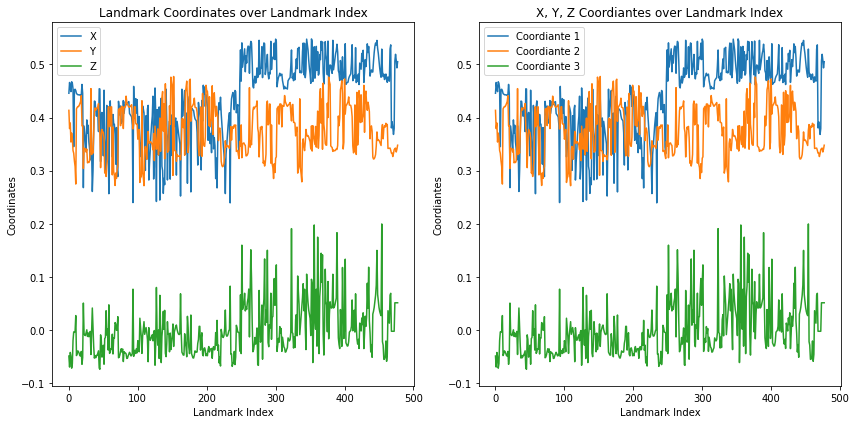

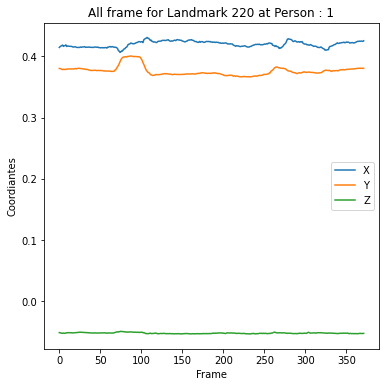

'\n    plot 요약\n    Args:\n        landmark_arr (array): 478개의 landmark에 대한 위치좌표를 다 보여준다.\n        x (float32): position x 좌표 index (:,:,:,0)\n        y (float32): position x 좌표 index (:,:,:,1)\n        z (float32): position x 좌표 index (:,:,:,2)\n        첫번쨰 플랏 그림은 landmark 별로 x,y,z의 값들을 파악할 수 있음 -> 위치 파악가능\n        두번째 그림은 프레임별 landmark 220번의 변화도를 파악할 수 있음 \n'

In [111]:
# landmark arr : (frame_index, person_index, landmark_index, (x,y,z))
# landmark_arr = np.load('./data/np/test2.npy')
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')
def landmark_analysis_plot(landmark_arr):
    print(f"landamark_arr shape : {landmark_arr.shape}")
    frame_idx, person_idx = 0, 0 #frame 별, 사람 별
    landmarks_person_frame = landmark_arr[frame_idx, person_idx] #frame별 x,y,z 좌표 변화
    num_landmarks = landmarks_person_frame.shape[0]

    #랜드마크 수의 변화를 나타내는 그래프
    plt.figure(figsize = (12,6))
    plt.subplot(121)
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 0], label='X')
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 1], label='Y')
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 2], label='Z')
    plt.title('Landmark Coordinates over Landmark Index')
    plt.xlabel('Landmark Index')
    plt.ylabel('Coordinates')
    plt.legend()

    # x, y, z변화를 나타내는 그래프
    plt.subplot(122)
    for i in range(3): #landmark index별 x,y,z의 
        plt.plot(range(num_landmarks), landmarks_person_frame[:, i], label=f'Coordiante {i+1}')
    plt.title('X, Y, Z Coordiantes over Landmark Index')
    plt.xlabel('Landmark Index')
    plt.ylabel('Coordiantes')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ## 전체 프레임 별 사람 별 특정 랜드마크에 대한 x,y,z 변화도 
    landmark_idx= 219 #220번쨰 랜드마크 

    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        x_coordiantes = landmark_arr[:, person_idx, landmark_idx, 0]
        y_coordiantes = landmark_arr[:, person_idx, landmark_idx, 1]
        z_coordiantes = landmark_arr[:, person_idx, landmark_idx, 2]
        plt.plot(range(landmark_arr.shape[0]), x_coordiantes, label=f'X')
        plt.plot(range(landmark_arr.shape[0]), y_coordiantes, label=f'Y')
        plt.plot(range(landmark_arr.shape[0]), z_coordiantes, label=f'Z')
        plt.title(f'All frame for Landmark {landmark_idx+1} at Person : {person_idx+1}')
        plt.xlabel('Frame')
        plt.ylabel(f'Coordiantes')
        plt.legend()
    plt.show()
    
            
landmark_analysis_plot(landmark_arr)
"""
    plot 요약
    Args:
        landmark_arr (array): 478개의 landmark에 대한 위치좌표를 다 보여준다.
        x (float32): position x 좌표 index (:,:,:,0)
        y (float32): position x 좌표 index (:,:,:,1)
        z (float32): position x 좌표 index (:,:,:,2)
        첫번쨰 플랏 그림은 landmark 별로 x,y,z의 값들을 파악할 수 있음 -> 위치 파악가능
        두번째 그림은 프레임별 landmark 220번의 변화도를 파악할 수 있음 
"""

#### 랜드마크 분석 2 : 위치별 인덱스 3D로 확인

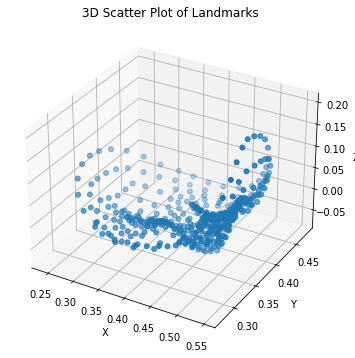

In [112]:
# 랜드마크 arr to df
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')
reshaped_arr = landmark_arr[0,0].reshape(-1,3)
landmark_df = pd.DataFrame(reshaped_arr, columns=['X', 'Y', 'Z'])
landmark_df
# 3D 산점도 그리기
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(landmark_df['X'], landmark_df['Y'], landmark_df['Z'], s=25, )  # s는 점의 크기를 나타냅니다.

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Landmarks')

plt.show()

In [113]:
# landmark_arr = np.load('./data/np/test2.npy')
landmark_arr = np.load(f'./data/analysis/'+video_info['name']+'.npy')

### 틱 관련 중요 부위 영역 분석

In [114]:
# 면적에 따른 프레임별 분석
def area_analysis(landmark_arr, tag):
    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    # 사람별로 프레임별 면적 계산
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        plt.plot(range(landmark_arr.shape[0]), landmark_arr[:,person_idx], label=f'{person_idx+1} person')
        plt.title(f'Compare All frame for {tag}')
        plt.xlabel('Frame')
        plt.ylabel(f'Area')
        plt.legend()
    plt.show()

In [115]:
# 삼각형 메쉬 데이터 면적 계산
def calculate_triangle_area(vertices):
    # 세점 A,B,C
    A, B, C = vertices
    
    #벡터 AB, AC 계산
    AB = B - A
    AC = C - A 
    
    #외적 계산
    cross_product = np.cross(AB, AC) 
    
    # 삼각형 넓이 계산
    area = 0.5 * np.linalg.norm(cross_product)
    
    return area
#부위의 모든 랜드마크 면적 계산 누적 함수 
def cal_area(landmark, landmark_dict, tag):
    # 각 점 x,y 좌표 추출
    try:
        iris_landmark = landmark[:, :, landmark_dict[tag], :]        
        # print(f' iris_landmark shape : {iris_landmark.shape}')
        # 각 프레임별 사람별 면적 저장하기 
        area_fr_per = np.zeros((iris_landmark.shape[0], iris_landmark.shape[1]))
        # 각프레임별 루프
        for frame_idx in range(iris_landmark.shape[0]):
            #각 사람별 루프
            for person_idx in range(iris_landmark.shape[1]):
                # 각 랜드마크별로 루프
                mesh_vetrices = iris_landmark[frame_idx, person_idx, :, : ]
                total_area = 0. 
                for landmark_idx in range(1, iris_landmark.shape[2]-1):
                    vetrices = np.array([
                        iris_landmark[frame_idx, person_idx, 0, :],
                        iris_landmark[frame_idx, person_idx, landmark_idx, :],
                        iris_landmark[frame_idx, person_idx, landmark_idx+1, :],
                        ])
                    total_area += calculate_triangle_area(vetrices)
                area_fr_per[frame_idx, person_idx] = total_area
                      
    except:
        print('Error')

    # print(f"{tag} area shape : {area_fr_per.shape}")

    return area_fr_per

L_eye_area = cal_area(landmark_arr, landmark_dict, 'L_eye')
R_eye_area = cal_area(landmark_arr, landmark_dict, 'R_eye')
L_iris_area = cal_area(landmark_arr, landmark_dict, 'L_iris')
R_iris_area = cal_area(landmark_arr, landmark_dict, 'R_iris')
L_eyebrow_area = cal_area(landmark_arr, landmark_dict, 'L_eyebrow')
R_eyebrow_area = cal_area(landmark_arr, landmark_dict, 'R_eyebrow')
Up_lips_area = cal_area(landmark_arr, landmark_dict, 'Up_lips')
Down_lips_area = cal_area(landmark_arr, landmark_dict, 'Down_lips')
Inner_lips_area = cal_area(landmark_arr, landmark_dict, 'Inner_lips')

area_dict = {
    'L_eye_area' : L_eye_area,
    'R_eye_area' : R_eye_area,
    'L_iris_area' : L_iris_area,
    'R_iris_area' : R_iris_area,
    'L_eyebrow_area' : L_eyebrow_area,
    'R_eyebrow_area' : R_eyebrow_area,
    'Up_lips_area' : Up_lips_area,
    'Down_lips_area' : Down_lips_area,
    'Inner_lips_area' : Inner_lips_area
}

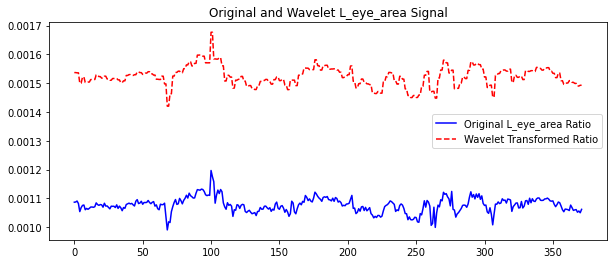

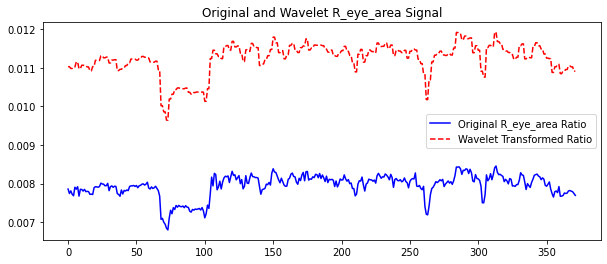

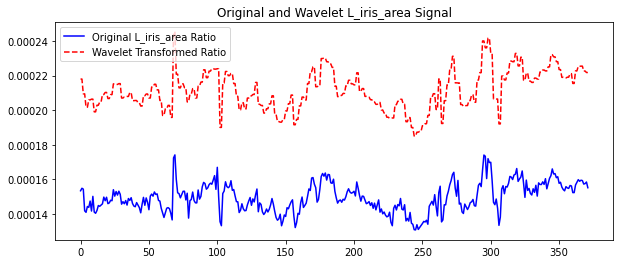

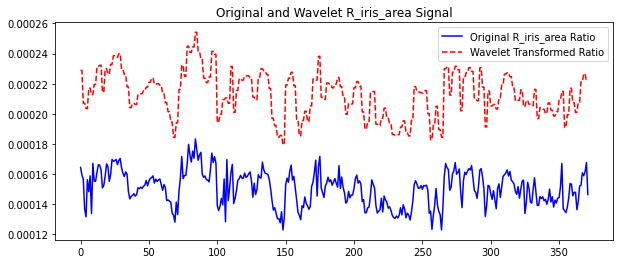

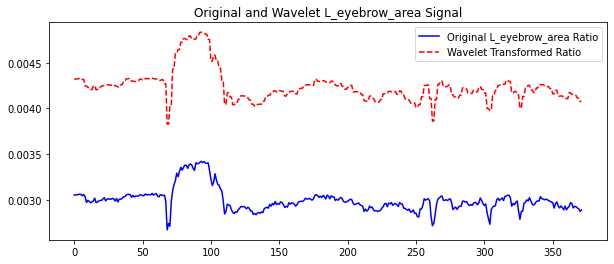

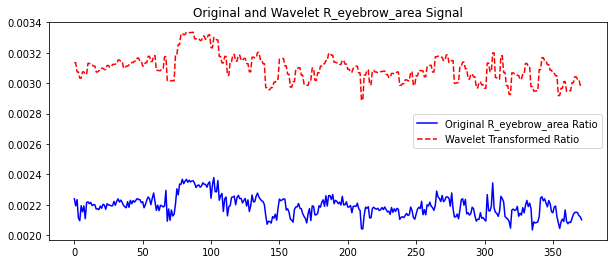

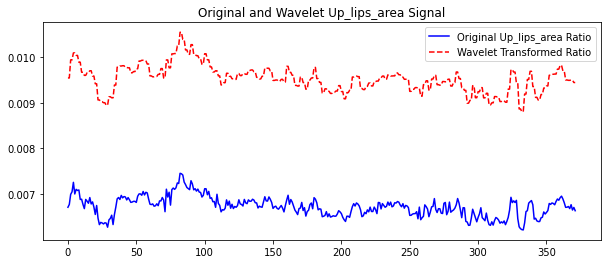

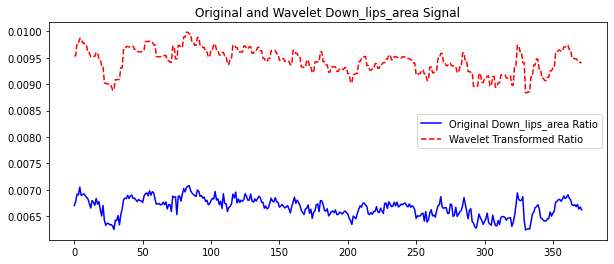

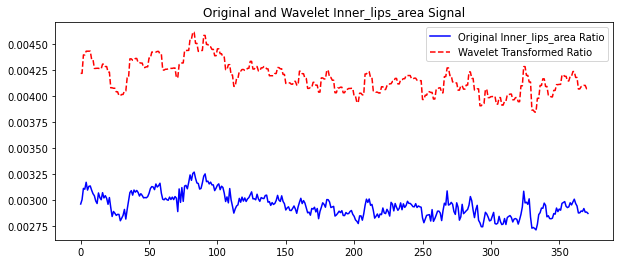

In [116]:
# 프레임별 면적 분석
def area_analysis(landmark_arr, tag):
    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    # 사람별로 프레임별 면적 계산
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        plt.plot(range(landmark_arr.shape[0]), landmark_arr[:,person_idx], label=f'{person_idx+1} person')
        plt.title(f'Compare All frame for {tag}')
        plt.xlabel('Frame')
        plt.ylabel(f'Area')
        plt.legend()
        plt.tight_layout()
    plt.savefig(os.path.join('./analysis', (video_info['name']+f"_{person_idx+1}p_{tag}.png")), bbox_inches = 'tight')
    plt.show()
       
def wavelet_padding_plot(tag, area_ratio):
    signal = area_ratio[:,0]
    wavelet = wavedec(signal, 'db1', level =1, mode = 'symmetric')[0]
    padding_wavelet_ratio = np.repeat(wavelet, 2)
    #복원된 신호와 원본 신호 시각화

    plt.figure(figsize=(10, 4))
    plt.plot(signal, label=f'Original {tag} Ratio', color='blue')
    plt.plot(padding_wavelet_ratio, label=f'Wavelet Transformed Ratio', color='red', linestyle='--')
    plt.title(f'Original and Wavelet {tag} Signal')
    plt.legend()
    plt.show()
    plt.close()

## 특정 부위에 대한 영역 분석 with Wavelet transform  
for key, value in area_dict.items():
    save_area(value, key, video_info)
    wavelet_padding_plot(key, value)



### 짝 눈 분석 : 두눈의 차이 변화도를 이용한 threshold 정하기

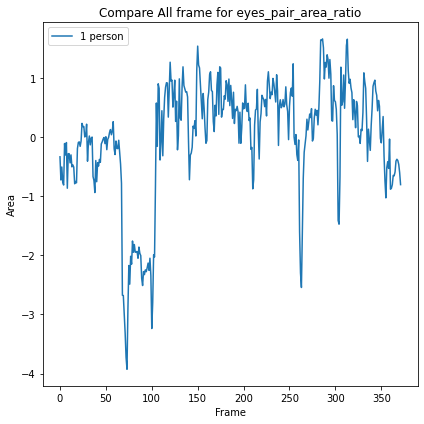

In [117]:
## 짝눈 분석 : 변화도가 큰 frame 구간 추출하기
eyes_pair_area_ratio = np.array([])
for i in range(len(area_dict['L_eye_area'])):
    eyes_pair_area_ratio = np.abs(area_dict['L_eye_area'] - area_dict['R_eye_area'])

area_analysis(z_score_norm(eyes_pair_area_ratio), 'eyes_pair_area_ratio')
# -> 변화도가 크다는 것은 즉 짝짜기로 눈을 감는 것이 크다는 것을 말한다.

### Eye Blink 분석 : 눈 감기 분석

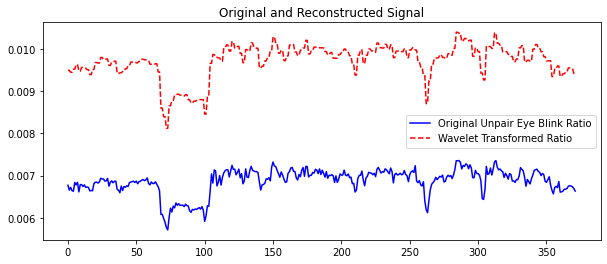

In [118]:
signal = eyes_pair_area_ratio[:,0]
wavelet = wavedec(signal, 'db1', level =1, mode = 'symmetric')[0]
padding_wavelet_ratio = np.repeat(wavelet, 2)
#복원된 신호와 원본 신호 시각화

plt.figure(figsize=(10, 4))
plt.plot(signal, label='Original Unpair Eye Blink Ratio', color='blue')
plt.plot(padding_wavelet_ratio, label='Wavelet Transformed Ratio', color='red', linestyle='--')
plt.title('Original and Reconstructed Signal')
plt.legend()
plt.show()
plt.close()

#-> blink threshold를 0.0045정도로 하여 조절해준다.

#### 눈 감기 분석 1 : L_eye_area의 변화량 계산 -> 눈을 감는 것에 대한 평균 점수 threshold를 정하기 위해 사용

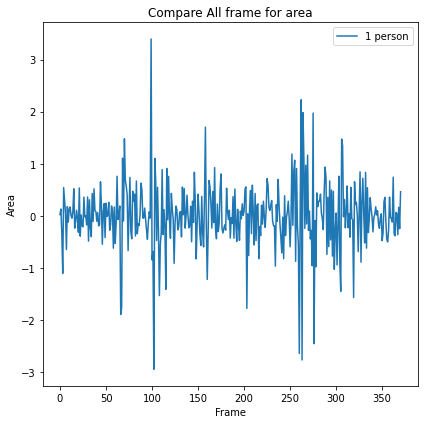

1초 - 2초: 평균 L_eye_area 변화량 = [-0.02123131]
2초 - 3초: 평균 L_eye_area 변화량 = [0.01674982]
3초 - 4초: 평균 L_eye_area 변화량 = [-0.02097774]
4초 - 5초: 평균 L_eye_area 변화량 = [0.06785893]
5초 - 6초: 평균 L_eye_area 변화량 = [-0.05993768]
6초 - 7초: 평균 L_eye_area 변화량 = [-0.03425408]
7초 - 8초: 평균 L_eye_area 변화량 = [0.05128522]
8초 - 9초: 평균 L_eye_area 변화량 = [0.0216453]
9초 - 10초: 평균 L_eye_area 변화량 = [-0.0520522]
10초 - 11초: 평균 L_eye_area 변화량 = [0.01457552]
11초 - 12초: 평균 L_eye_area 변화량 = [-0.12705564]
12초 - 13초: 평균 L_eye_area 변화량 = [0.13331111]
13초 - 14초: 평균 L_eye_area 변화량 = [0.00566123]
14초 - 15초: 평균 L_eye_area 변화량 = [0.01076237]
15초 - 16초: 평균 L_eye_area 변화량 = [-0.04664937]


In [119]:
## L_eye_area의 변화량 계산 -> 눈을 감는 것에 대한 threshold를 정하기 위해 사용
area = z_score_norm(area_dict['L_eye_area'])

fps = 24
num_frames = len(area)
seconds = num_frames / fps 
delta_L_eye_area = np.array([area[i+1] - area[i] for i in range(num_frames-1)])
area_analysis(delta_L_eye_area, 'area')

# 초당 평균 변화량 계산
average_change_per_second = sum(delta_L_eye_area) / seconds

# 초 범위로 평균 변화량 계산
interval_seconds = 1  # 초 범위
num_intervals = int(seconds / interval_seconds)

average_change_by_interval = [sum(delta_L_eye_area[i*fps:(i+1)*fps]) / fps for i in range(num_intervals)]

# 결과 출력
for i, avg_change in enumerate(average_change_by_interval):
    print(f"{i+1}초 - {i+2}초: 평균 L_eye_area 변화량 = {avg_change}")




#### 눈 감기 분석 2 : 눈을 감는 것에 데한 종횡비 threshold를 정하기 위한 분석


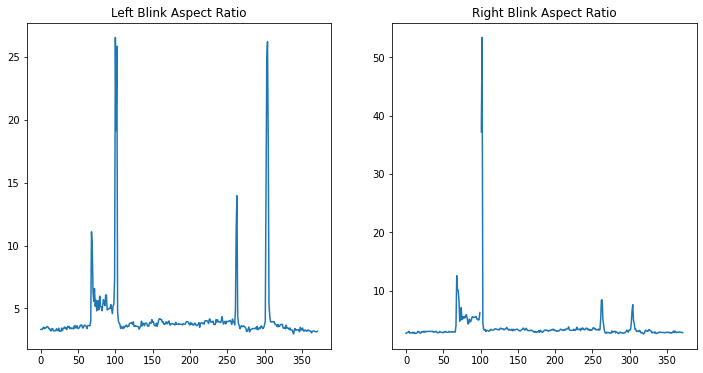

In [120]:
## 눈을 감는 것에 데한 종횡비 threshold를 정하기 위한 분석
def blink_z_score_norm(arr):
    # z-score normalization
    left_mean_val = np.mean(arr[:,0])
    left_std_dev = np.std(arr)
    
    right_mean_val = np.mean(arr[:,1])
    right_std_dev = np.std(arr)
    return (arr[:,0] - left_mean_val) / left_std_dev, (arr[:,1] - right_mean_val) / right_std_dev

## 눈 감는 것에 대한 종횡비 비교 분석
# left_right_norm = blink_arr[:,1:]
blink_arr = np.array(blink_frame)
# left_norm, right_norm = blink_z_score_norm(blink_arr[:,1:])
left_norm, right_norm = blink_arr[:,1], blink_arr[:,2]
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(len(left_norm)), left_norm)
plt.title('Left Blink Aspect Ratio')
plt.subplot(122)
plt.plot(range(len(left_norm)), right_norm)
plt.title('Right Blink Aspect Ratio')
# plt.legend()
plt.show()

### 머리 흔들림 차이 분석 : 흔들림에 대한 프레임별 분석하여 점수화 threshold 정하기

In [133]:
# frame 별 hanging seq 분석
hanging_array = np.zeros((video_info['total frame'],1))
# hanging_array[np.array(hanging_frame[:,0]).astype(int)] = np.array(hanging_frame)[:,1]
for idx, point in enumerate(np.array(hanging_frame)[:,0].astype(int)):
    hanging_array[point] = hanging_frame[idx][1]*10

# hanging_array를 플로팅
plt.plot(range(1, video_info['total frame']+1), hanging_array, label='Hanging Sequence')
plt.xlabel('Frame Index')
plt.ylabel('Hanging Value')
plt.title('Hanging Sequence Over Frames')
plt.legend()
plt.show()

"""
    hanging threshold 정하기 -> 0.05 이상이면 hardly hanging 으로 판단
"""

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

IndexError: index 372 is out of bounds for axis 0 with size 372

## Tic/Non-tic 비교분석 (진행중) Tic/Non-Tic Feature 추출 및 분석
* 일부(2,2) or 전체 (2,2) → 먼저 일부만 해서 분석하자
* 머리 흔들림 차이에 대한 Tic / Non-Tic 분석
* 평균 정해진 시간에 따른 눈 감기 횟수 분석
* 짝눈에 대한 횟수 분석 Tic

### 일부(2,2) or 전체 (2,2) → 먼저 일부만 해서 분석하자

In [ ]:
## tic 3명 / non-tic 3명 

#점수 

In [171]:
values.shape

(2, 3)

### 머리 흔들림 차이에 대한 Tic / Non-Tic 분석

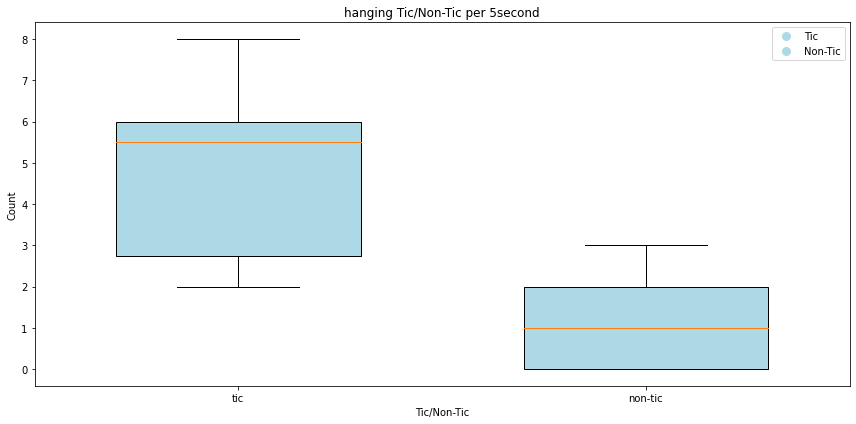

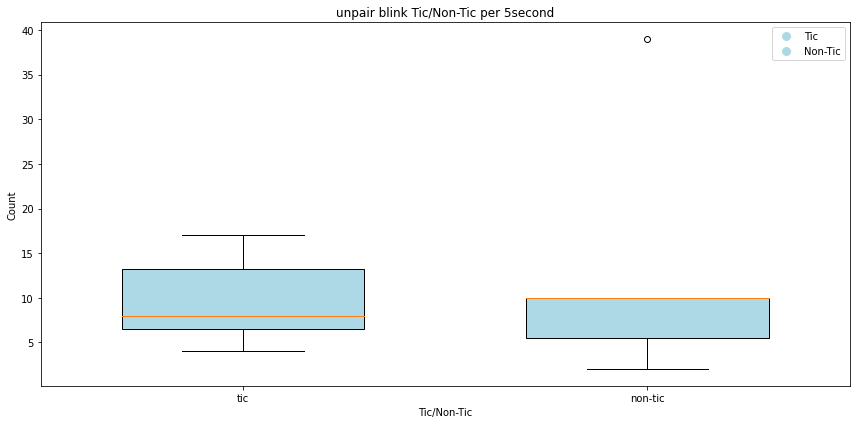

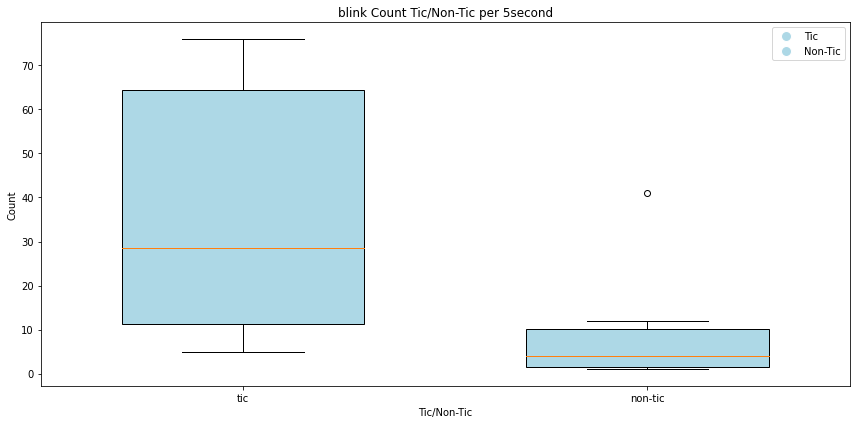

In [260]:
import matplotlib.pyplot as plt

def box_plot_seperate(tic_values, non_tic_values, tag):
    groups = ['tic', 'non-tic']
    # tic_values = [5, 6, 6]
    # non_tic_values = [1, 3, 2]

    # 박스 플롯 생성
    fig, ax = plt.subplots(figsize= (12,6))
    ax.boxplot([tic_values, non_tic_values], positions=[1, 2], widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='lightblue', edgecolor='black'))

    # 축 및 라벨 설정
    ax.set_xticks([1, 2])
    ax.set_xticklabels(groups)
    ax.set_xlabel('Tic/Non-Tic')
    ax.set_ylabel('Count')
    ax.set_title(f'{tag} Tic/Non-Tic per 5second')

    # legend 추가
    tic_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Tic')
    non_tic_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Non-Tic')
    ax.legend(handles=[tic_patch, non_tic_patch])

    plt.tight_layout()
    # 그래프 표시
    plt.show()
    plt.close()


hanging_tic_values = [0.4, 0.6, 0.6, 0.2, 0.2, 0.8]
non_hanging_tic_values = [0.2, 0, 0, 0, 0, 0]
box_plot_seperate(hanging_tic_values, non_hanging_tic_values, 'hanging Score')

unpair_eye_tic_values = [0.2, 1.0, 0.4, 1.0, 0.6]
non_unpair_eye_tic_values = [10, 39, 10, 2, 10, 4]
box_plot_seperate(unpair_eye_tic_values, non_unpair_eye_tic_values, 'unpair blink Score')

blink_tic_values = [5, 42, 76, 72, 15, 10]
non_blink_tic_values = [12, 41, 5, 1, 1, 3]
box_plot_seperate(blink_tic_values, non_blink_tic_values, 'blink Count Score')



### 평균 정해진 시간에 따른 눈 감기 횟수 분석

### 짝눈에 대한 횟수 분석 Tic